In [281]:
from google.colab import drive
drive.mount('/content/drive') # remove the cell if colab is not used

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [282]:
import pandas as pd
import numpy as np
from pathlib import Path
base_path = Path('/content/drive/MyDrive/data') # Pass path to data folder here, e.g. Path('/content/drive/MyDrive/data') if using Google Drive

# Analiza i przetwarzanie danych na temat Titanica

#### Wyobraź sobie, że pewnego wakacyjnego dnia, będąc na plaży w pełnym słońcu, odbierasz telefon od nieznanego numeru.
Robisz to niechętnie — zasłużyłeś/aś przecież na odpoczynek i chcesz mieć ten czas tylko dla siebie. Już masz na końcu języka wymijającą odpowiedź, gdy nagle z drugiej strony słyszysz:
„Czy jesteś gotowy, by tego lata rozwikłać jedną z największych zagadek ludzkości?”

Jako osoba z natury ciekawa świata i ze świetnym umysłem analitycznym, szybko zapominasz o plaży i wakacjach. Zaintrygowany/a dopytujesz o szczegóły, ale rozmówca nie chce zdradzić zbyt wiele. Wiadomo jedynie, że chodzi o *zatonięcie Titanica w 1914* roku, a celem misji jest ustalenie, które osoby miały szansę przeżyć.

**Ty** — jako **renomowany analityk danych** — byłeś/byłaś ich pierwszym wyborem do analizy i oczyszczenia danych. Mimo wątpliwości postanawiasz podjąć się zadania, mając nadzieję, że twoja wiedza może zostać praktycznie wykorzystana w słusznym celu.


#### Twoim celem będzie przeanalizowanie i przetworzenie zbioru danych w taki sposób, by mógł on być użyty do nauki modelu do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

(Uwaga: w tym zadaniu nie będziesz trenować modeli, ta przyjemność spotka cię w następnych notebookach)

Poniżej znajdziesz pytania, które mogą być pomocne w analizie, oraz odwołania do poszczególnych sekcji z notebooka do lekcji:

- Czy wszystkie kolumny są istotne w kontekście zadania?
- Czy występują brakujące wartości? Jeśli tak, to jak je uzupełnisz? (sekcja #2.1)
- Czy typy danych są odpowiednie do znaczenia kolumny? (sekcja #1.3)
- Czy dystrybucje danych mają rozkłady normalne, czy asymetryczne? (sekcja #4.1 + wykład)
- Która zmienna oznacza predykowaną klasę?
- Jaki jest rozkład zmiennej predykowanej względem zmiennych kategorialnych, jak i numerycznych? (sekcja #4.1)
- Czy końcowe rozkłady zawierają wartości skrajne? (sekcja #4.2 + wykład)

Wymagania:

- Zbiór musi być oczyszczony, tj. finalnie nie powinien mieć brakujących wartości (sekcja #2.1)
- Zbiór musi zawierać co najmniej dwie dodatkowe kolumny, które mogą wzbogacić informacje zawarte w zbiorze (sekcje #1.5 i #2.2)
- Cechy kategorialne powinny być zakodowane, postaraj się dobrać odpowiedni sposób (sekcja #2.3)
- Zbadaj, czy występują skrajne wartości (outliery) zarówno dla wartości numerycznych, jak i dla kategorialnych
- Każda cecha powinna być zwizualizowana co najmniej raz. Sam(a) zastanów się, czy warto wizualizować cechy parami w celu odkrycia zależności między nimi (sekcja #4.4)
- Nie ma ograniczenia na liczbę komórek, ale zastanów się, czy dana wizualizacja/obliczenie jest przydatne w całej analizie, czy po prostu sobie "egzystuje" bez żadnych wniosków

Zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Poniżej zamieszczamy tabelę z wyjaśnieniem poszczególnych kolumn:

| Kolumna      | Opis                                                                            |
| ------------ | ------------------------------------------------------------------------------- |
| **Survived** | Czy pasażer przeżył (0 = nie, 1 = tak).                                         |
| **Pclass**   | Klasa podróży (1 = I klasa, 2 = II klasa, 3 = III klasa).                       |
| **Name**     | Imię i nazwisko pasażera.                                                       |
| **Sex**      | Płeć pasażera (male = mężczyzna, female = kobieta).                             |
| **Age**      | Wiek pasażera w latach.                                                         |
| **SibSp**    | Liczba rodzeństwa i małżonków na pokładzie.                                     |
| **Parch**    | Liczba rodziców i dzieci na pokładzie.                                          |
| **Ticket**   | Numer biletu.                                                                   |
| **Fare**     | Cena biletu.                                                                    |
| **Cabin**    | Numer kabiny pasażera                                     |
| **Embarked** | Port, w którym pasażer wsiadł (C = Cherbourg, Q = Queenstown, S = Southampton). |
                                                         |


In [283]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')
titanic_df = titanic_df.drop(['Name','Ticket'],axis=1)
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,NaN,S
2,1,1,female,38.0,1,0,71.2833,C85,C
3,1,3,female,26.0,0,0,7.9250,NaN,S
4,1,1,female,35.0,1,0,53.1000,C123,S
5,0,3,male,35.0,0,0,8.0500,NaN,S


Czy wszystkie kolumny są istotne w kontekście zadania?
W kontekście zadania kolumny: Name i Ticket są zbędne

In [284]:
def get_percentage_missing(df, axis):
  """
    Zwraca procent brakujących wartości (NaN) w wierszach lub kolumnach DataFrame.

    df : pandas.DataFrame
        Tabela danych, dla której liczone są braki.

    axis : int
        Oś, względem której obliczane są braki:
        - 0 : procent braków w każdej kolumnie
        - 1 : procent braków w każdym wierszu
  """
  missing_rows = df.isna().sum(axis=axis)
  missing_rows_perc = np.round(missing_rows / df.shape[axis] * 100, 2)
  return missing_rows_perc[missing_rows_perc > 0]


In [285]:
missing_data = get_percentage_missing(titanic_df, axis=0)
missing_data

,0
Age,19.87
Fare,11.00
Cabin,77.10
Embarked,0.22


Dla kategorii Cabin można użyć metody stworzenia nowej klasy "Unknown". Dla kategorii Fare i Age należy sprawdzić rozkład wartości, aby dopasować sposób uzupełnienia danych. W przypadku Embarked należy sprawdzić czy istnieje moda i ją uzupełnić, w przeciwnym wypadku należy użyć rozkładu danych.

In [286]:
titanic_df['Cabin']=titanic_df['Cabin'].fillna('Unknown')

In [287]:
import matplotlib.pyplot as plt
import seaborn as sns

In [288]:
def plot_numeric_histogram(df, column_name):
    """
    Plots a histogram for the specified column in the DataFrame,
    and adds vertical lines for the mean and median.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to plot.
    Returns:
        None. Displays the histogram.
    """

    data = df[column_name].dropna()
    mean_val = data.mean()
    median_val = data.median()

    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=30, color='steelblue', edgecolor='black')
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

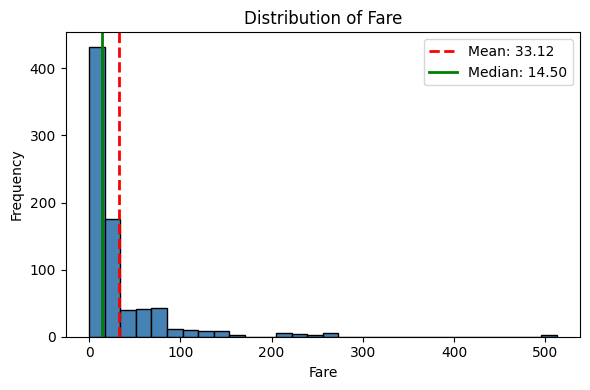

In [289]:
plot_numeric_histogram(titanic_df, 'Fare')

Rozkład Fare jest skośny prawostronnie, dlatego do uzupełnienia danych należy użyć mediany.

In [290]:
fare_median=titanic_df['Fare'].median()
titanic_df['Fare']=titanic_df['Fare'].fillna(fare_median)

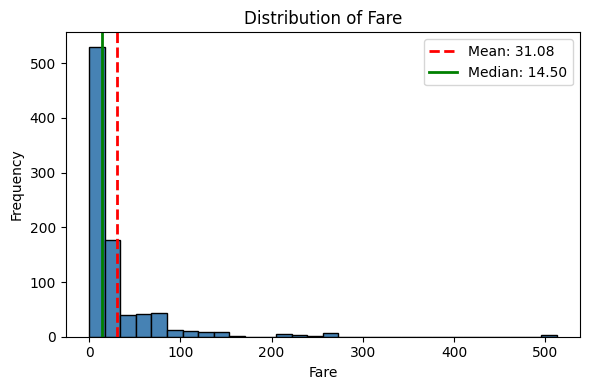

In [291]:
plot_numeric_histogram(titanic_df, 'Fare')

Wykres dystrybucji Fare po uzupełnieniu danych, następnie należy wykonać podobne kroki dla Age.

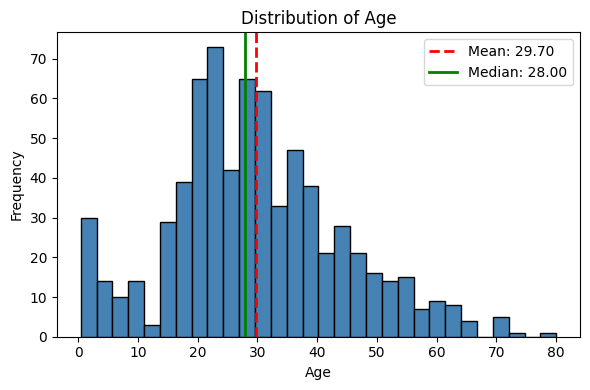

In [292]:
plot_numeric_histogram(titanic_df, 'Age')

Wykres dystrybucji Age również jest skośny prawostronnie, dlatego należy wykorzystać uzupełnienie danych medianą.

In [293]:
age_median=titanic_df['Age'].median()
titanic_df['Age']=titanic_df['Age'].fillna(age_median)

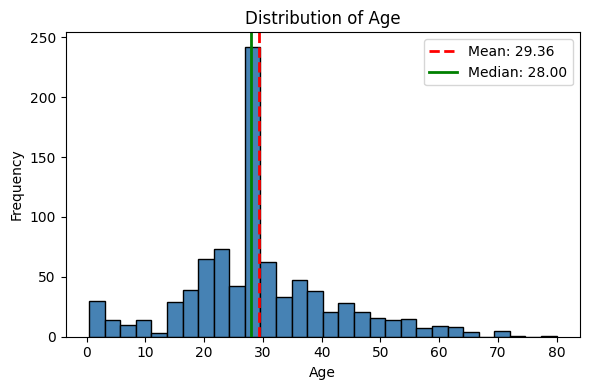

In [294]:
plot_numeric_histogram(titanic_df, 'Age')

Następnie należy sprawdzić rozkład embarked i odpowiednio uzupełnić.

In [295]:
def plot_categorical_column(df, column_name):
    """
    Plots a bar chart for the specified categorical column.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the categorical column to plot.
    Returns:
        None. Displays the bar chart.
    """

    # count occurrences of each category
    counts = df[column_name].value_counts()

    plt.figure(figsize=(6, 4))
    counts.plot(kind='bar', color='steelblue', edgecolor='black')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()


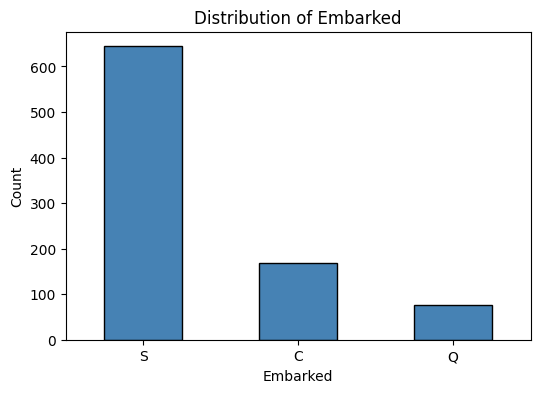

In [296]:
plot_categorical_column(titanic_df, 'Embarked')

Można zauważyć, że istnieje moda S, dlatego nią uzupełnię 0.22% danych.

In [297]:
titanic_df['Embarked']=titanic_df['Embarked'].fillna('S')

In [298]:
titanic_df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Cabin,0
Embarked,0


In [299]:
titanic_df.dtypes

,0
Survived,int64
Pclass,int64
Sex,object
Age,float64
SibSp,int64
Parch,int64
Fare,float64
Cabin,object
Embarked,object


Następnie należy zmienić typy object na pythonowe.

In [300]:
titanic_df = titanic_df.convert_dtypes()
titanic_df.dtypes

,0
Survived,Int64
Pclass,Int64
Sex,string[python]
Age,Float64
SibSp,Int64
Parch,Int64
Fare,Float64
Cabin,string[python]
Embarked,string[python]


Dla ułatwienia analizy danych dodajemy 2 dodatkowe kategorie. Zmienna has_family, która będzie oznaczać posiadanie członka rodziny przez pasażera(0 dla false i 1 dla true). Zmienna CabinType będzie oznaczać strefę, w której dany pasażer ma swoją kabinę. Brak danych zostanie uzupełniony literą 'U'.

In [301]:
titanic_df['has_family'] = titanic_df.apply(lambda x: 1 if x['SibSp'] > 0 or x['Parch'] > 0 else 0, axis=1)

In [302]:
titanic_df['CabinType'] = titanic_df['Cabin'].str[0].fillna("Unknown")
titanic_df.groupby('Pclass')[['CabinType']].value_counts()

Pclass  CabinType
1       C             59
        B             47
        U             40
        D             29
        E             25
        A             15
        T              1
2       U            168
        F              8
        D              4
        E              4
3       U            479
        F              5
        G              4
        E              3
Name: count, dtype: int64

Jak można zauważyć każdy sektor ma w sobie 1,2 oraz 3 klasę. Podział na litery to prawdopodobnie podział statku na części patrząc od dziobu. Można również zauważyć największy brak danych dla klas 2 i 3.

In [324]:
titanic_df.groupby('Embarked')[['CabinType']].value_counts()

Embarked  CabinType
0         8             99
          1             22
          2             21
          3             13
          0              7
          4              5
          5              1
1         8             73
          2              2
          4              1
          5              1
2         8            515
          2             36
          4             26
          1             25
          3             20
          5             11
          0              8
          6              4
          7              1
Name: count, dtype: int64

Jak można zauważyć najwięcej osób wsiadło w porcie Southampton. Mamy o nich również najmniej danych co do Cabin.

Dla ułatwienia można również zmienić nazwę Survived na has_survived

In [303]:
titanic_df=titanic_df.rename({'Survived': 'has_survived'}, axis=1)

Dystrybucje danych wyglądają następująco.

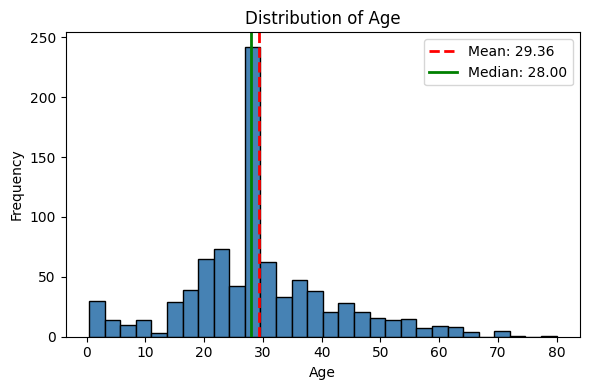

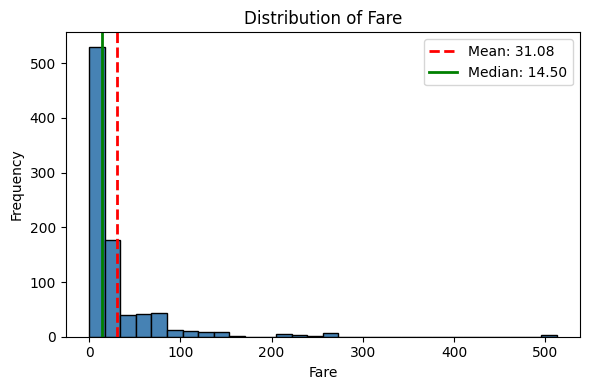

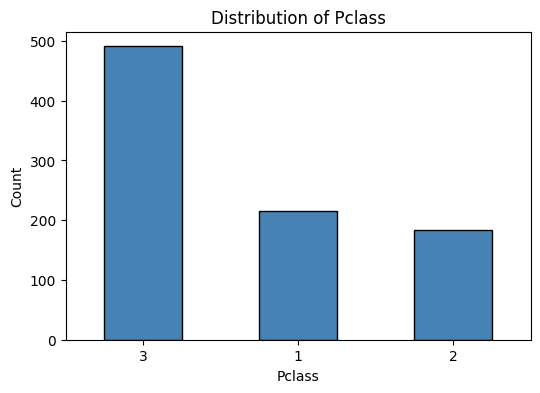

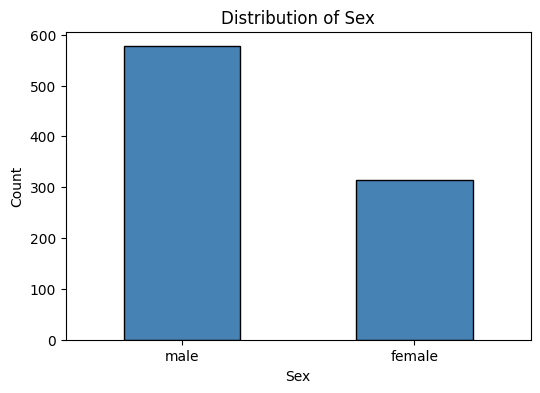

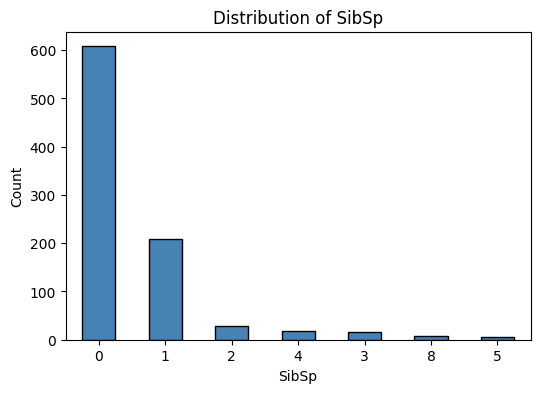

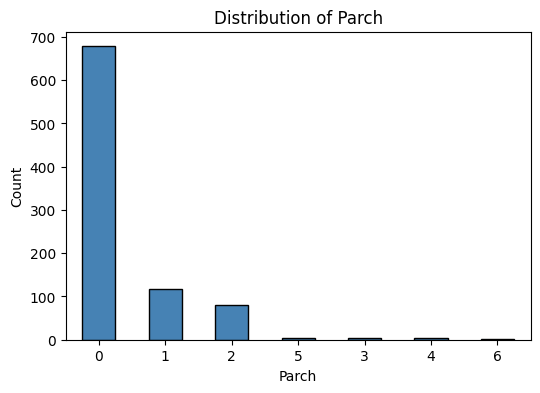

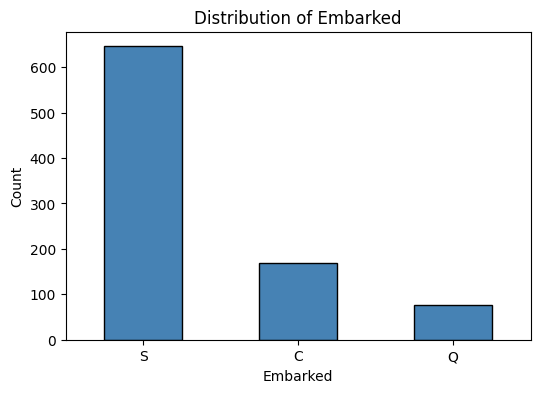

In [304]:
plot_numeric_histogram(titanic_df, 'Age')
plot_numeric_histogram(titanic_df, 'Fare')
plot_categorical_column(titanic_df, 'Pclass')
plot_categorical_column(titanic_df, 'Sex')
plot_categorical_column(titanic_df, 'SibSp')
plot_categorical_column(titanic_df, 'Parch')
plot_categorical_column(titanic_df, 'Embarked')


Jak można zauważyć przy danych nie występuje rozkład normalny, tylko asymetryczny.

Klasa predykowana to klasa has_survived.

**Kodowanie danych**


---

Następnie dane należy zakodować dane. Dla zmiennej sex male będzie 0, a female 1.

Dla Cabin została wcześniej utworzona dodatkowa zmienna CabinType, dla której każdy sektor dostanie własną liczbę zaczynając od 0.

Dla Embarked należy również przypisać wartości idąc od 0.

In [305]:
mappingCabinType = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'T': 7,
    'U': 8
}
titanic_df['CabinType'] = titanic_df['CabinType'].map(mappingCabinType)

In [306]:
mappingSex = {
    'male': 0,
    'female': 1
}
titanic_df['Sex'] = titanic_df['Sex'].map(mappingSex)

In [307]:
mappingEmbarked = {
    'C': 0,
    'Q': 1,
    'S': 2
}
titanic_df['Embarked'] = titanic_df['Embarked'].map(mappingEmbarked)

Możemy również pozbyć się zmniennej Cabin, ponieważ utrudnia ona jedynie analizę i została zastąpiona przez CabinType.

In [308]:
titanic_df=titanic_df.drop(['Cabin'],axis=1)

Finalna tablica danych:

In [309]:
titanic_df.head()

,has_survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,has_family,CabinType
PassengerId,,,,,,,,,,
1,0,3,0,22.0,1,0,7.25,2,1,8
2,1,1,1,38.0,1,0,71.2833,0,1,2
3,1,3,1,26.0,0,0,7.925,2,0,8
4,1,1,1,35.0,1,0,53.1,2,1,2
5,0,3,0,35.0,0,0,8.05,2,0,8


Następnie warto zrobić Macierz korelacji, aby zauważyć jakie zmienne są ze sobą połączone.

In [310]:
def plot_correlation_matrix(df):
    """
    Plots a heatmap showing the correlation matrix for numeric columns in the DataFrame.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing numeric data.
    Returns:
        None. Displays the correlation heatmap.
    """
    # compute correlation matrix only for numeric columns
    corr = df.corr(numeric_only=True)

    # fmt=".2f" rounds the number to 0.01
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()


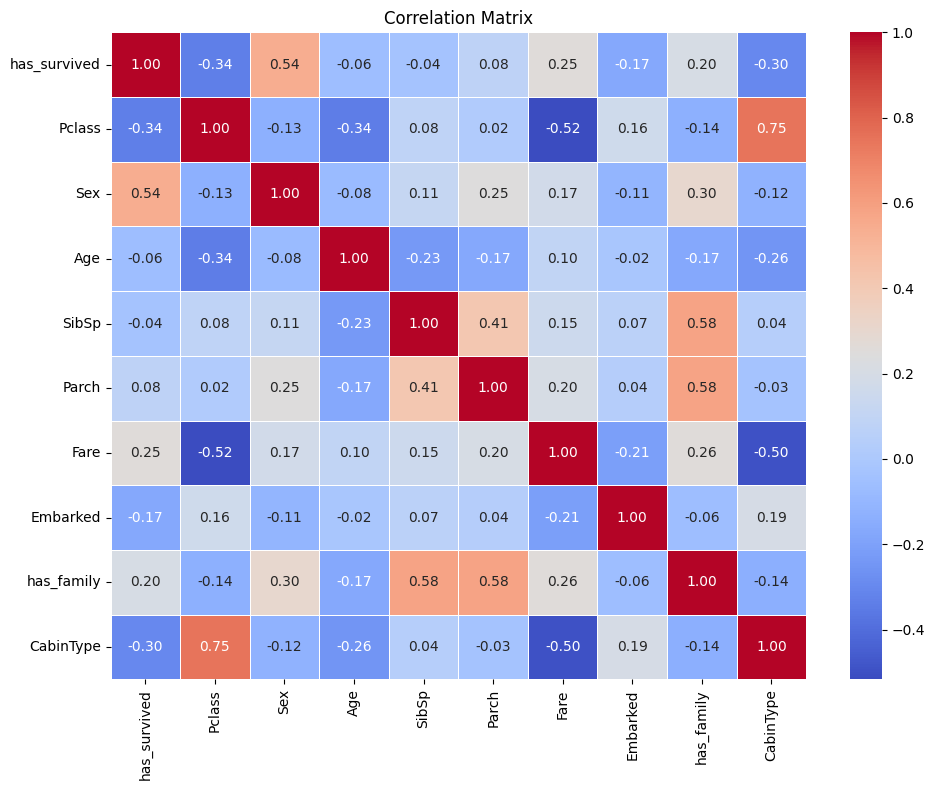

In [311]:
plot_correlation_matrix(titanic_df)

Na wykresie powyżej można zauważyć korelację pomiędzy: has_survived oraz Pclass, has_survived oraz Sex, CabinType oraz Fare, has_survived oraz CabinType.

In [312]:
def plot_mean(df, group_by_column, value_column):

    mean=df.groupby([group_by_column])[value_column].mean()

    plt.figure(figsize=(8, 6))
    mean.plot(kind='bar', color='steelblue', edgecolor='black')

    plt.title(f'Średnia {value_column} w zależności od {group_by_column}')
    plt.xlabel(group_by_column)
    plt.ylabel(f'Średnia {value_column}')
    plt.xticks(rotation=0)
    plt.show()

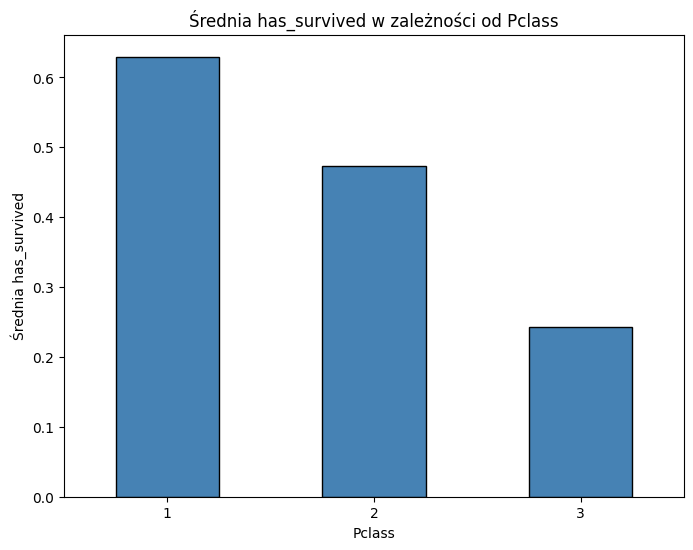

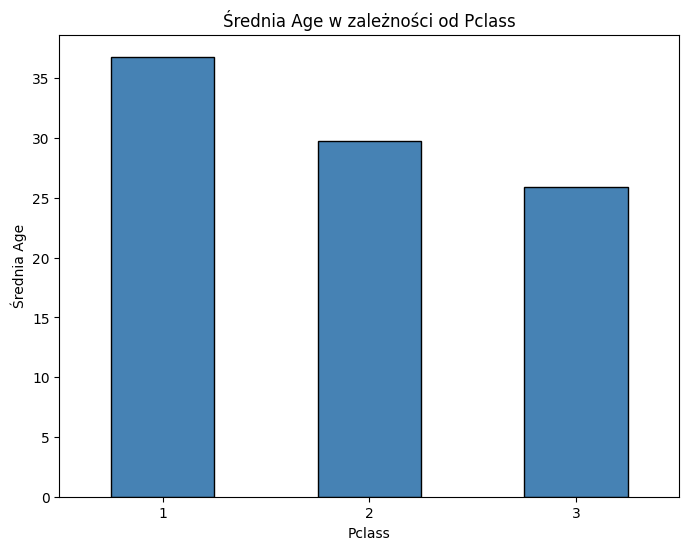

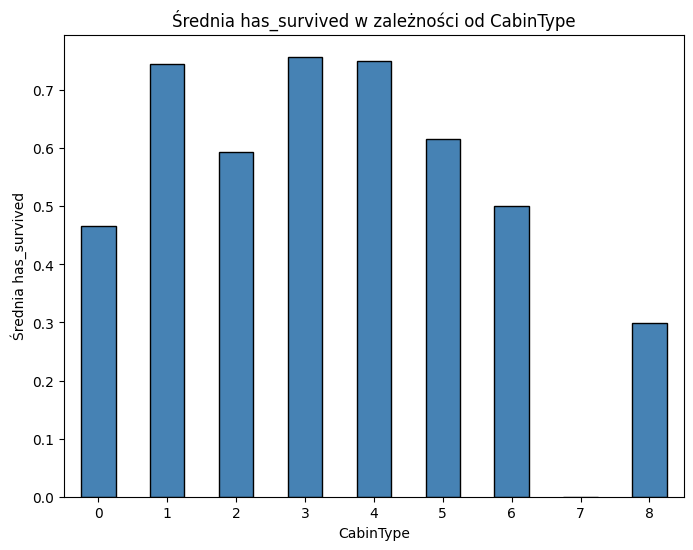

In [313]:

plot_mean(titanic_df, 'Pclass', 'has_survived')
plot_mean(titanic_df, 'Pclass', 'Age')
plot_mean(titanic_df, 'CabinType', 'has_survived')

Średnia przeżywalność jest najwyższa w 1 klasie. Jak można zauważyć były w niej statystycznie najstarsze osoby. Można również zauważyć wysoki procent przeżywalności w strefach 3 oraz 4.

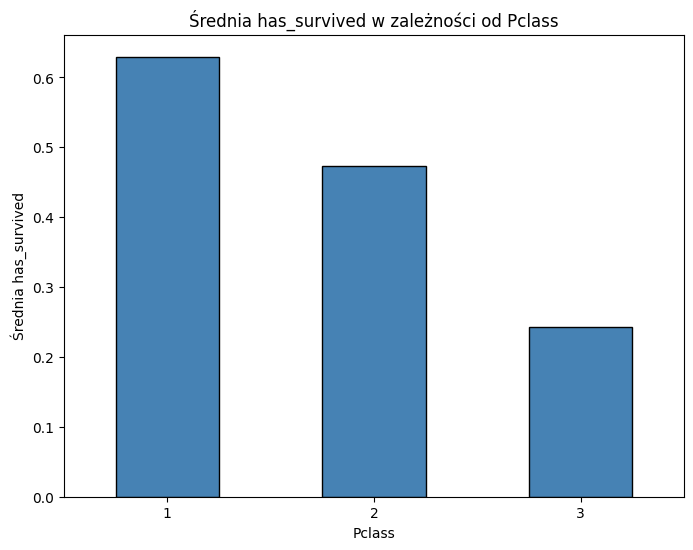

In [314]:
plot_mean(titanic_df, 'Pclass', 'has_survived')

Jak można zauważyć najwięcej osób przeżyło w klasie 1. Jest to prawdopodobnie spowodowane wyższym umiejscowieniem 1 klasy.

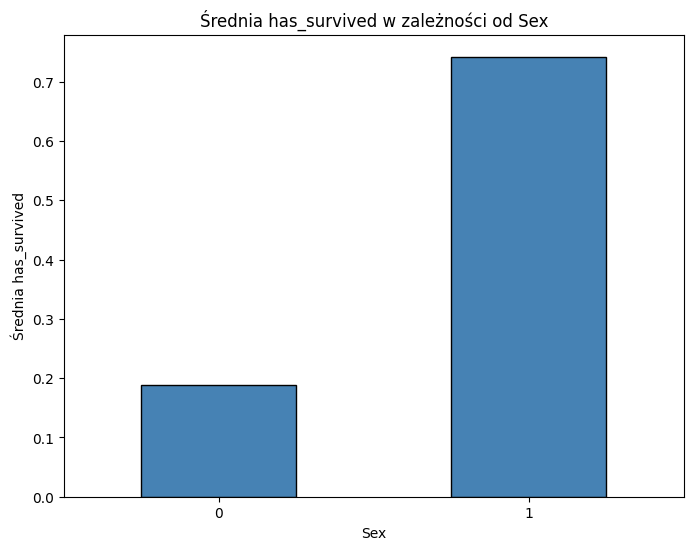

In [315]:
titanic_df_copy=titanic_df.copy()
plot_mean(titanic_df_copy, 'Sex', 'has_survived')

Wykres przeżywalności od płci

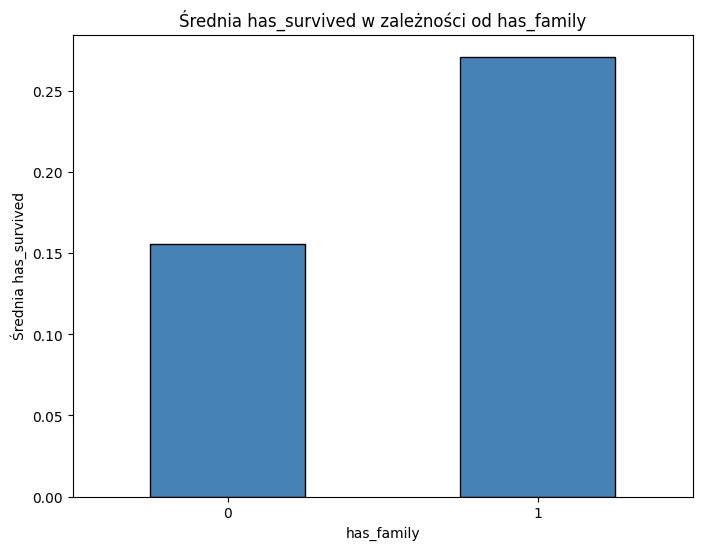

In [316]:
titanic_df_copy = titanic_df_copy[titanic_df_copy['Sex'] == 0].copy()
plot_mean(titanic_df_copy, 'has_family', 'has_survived')

Wykres przeżywalności mężczyzn bez rodzin vs z rodzinami. Jak można zauważyć
przeżywalność mężczyzn była większa, gdy posiadali rodzinę.

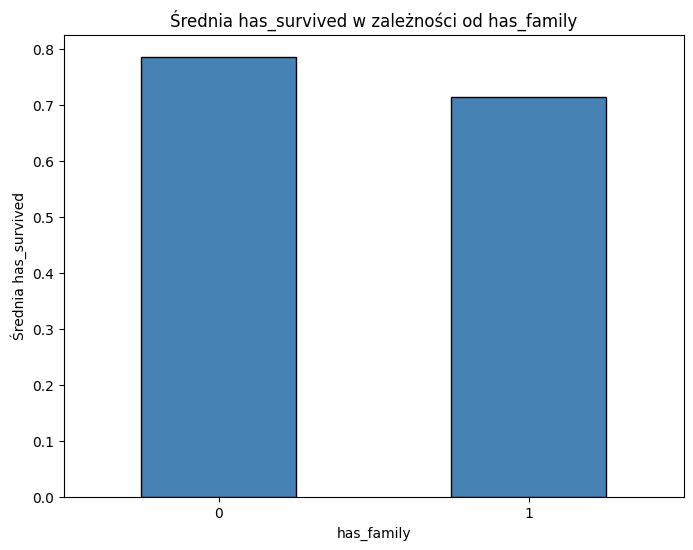

In [317]:
titanic_df_copy = titanic_df.copy()
titanic_df_copy = titanic_df[titanic_df['Sex'] == 1].copy()
plot_mean(titanic_df_copy, 'has_family', 'has_survived')

Wykres przeżywalności kobiet bez rodzin vs z rodzinami. Jak można zauważyć
przeżywalność kobiet była większa, gdy nie posiadali rodziny.

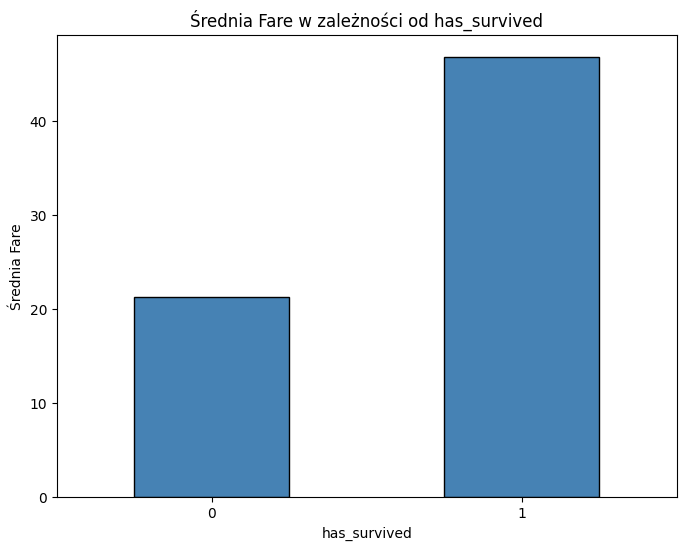

In [318]:
plot_mean(titanic_df, 'has_survived', 'Fare')

Jak widać na powyższym wykresie osoby bogatsze miały większe szanse na przeżycie.

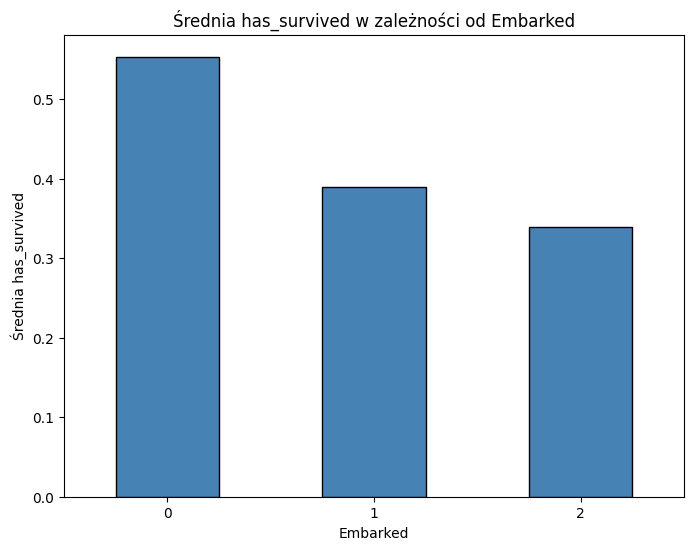

In [319]:
plot_mean(titanic_df, 'Embarked', 'has_survived')

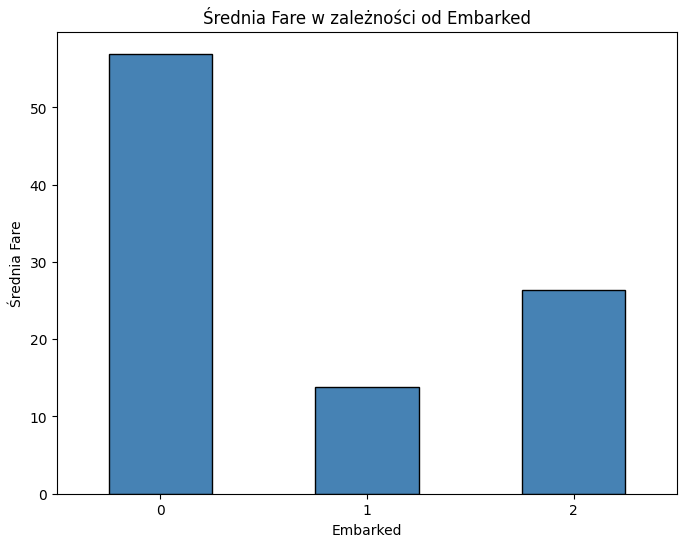

In [320]:
plot_mean(titanic_df, 'Embarked', 'Fare')

Jak można zauważyć największa przeżywalność mają osoby wsiadające w porcie Cherbourg. Kupiły one stastystycznie najdroższe bilety.

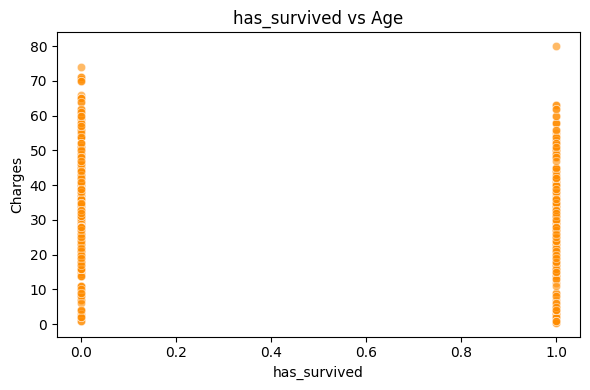

In [327]:
scatterplot(titanic_df, 'has_survived', 'Age')



---
Następnym krokiem w analizie jest znalezienie outlierów.


In [321]:
def boxplot(df, column_name):
    """
    Displays a boxplot of the choosen column to show its distribution.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the categorical column to plot.
    Returns:
        None. Displays the bar chart.
    """
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[column_name].dropna(), color='lightgreen') # as you can see, you can use sns and plt at the same time
    plt.title(f'Distribution of {column_name} (boxplot)')
    plt.xlabel(column_name)

    plt.show()

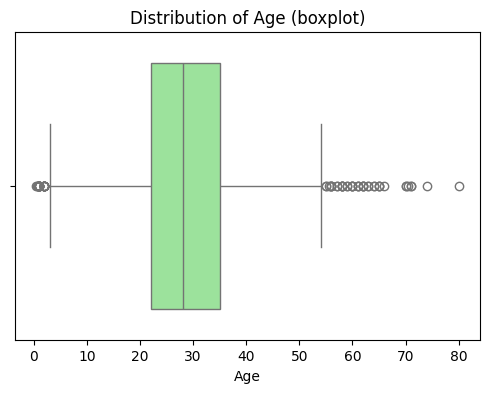

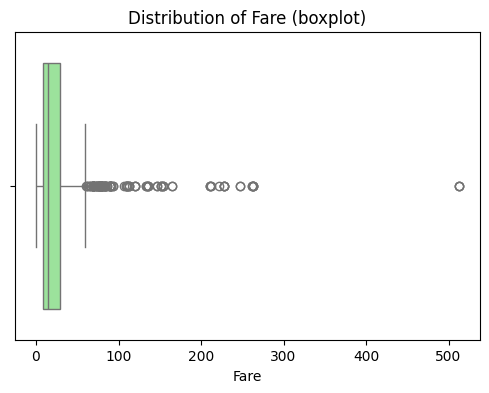

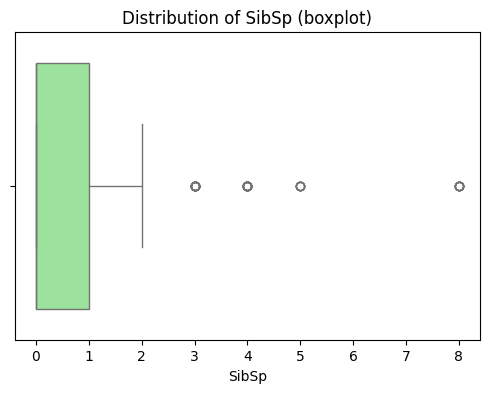

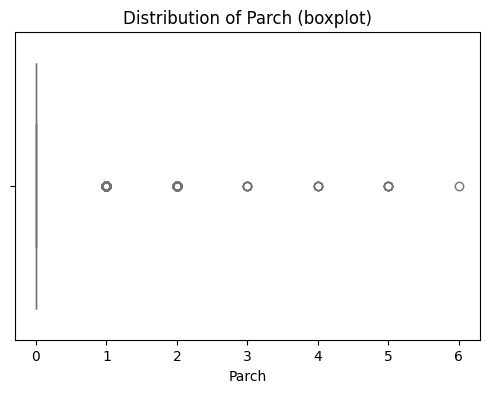

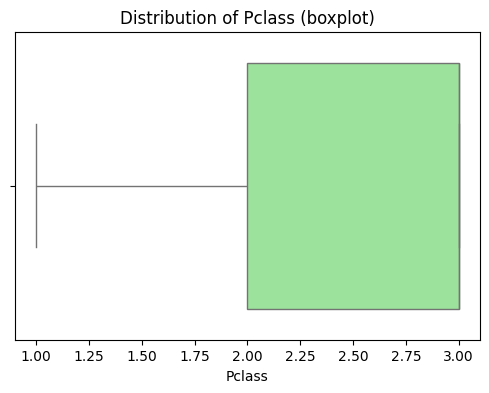

In [323]:
boxplot(titanic_df, 'Age')
boxplot(titanic_df, 'Fare')
boxplot(titanic_df, 'SibSp')
boxplot(titanic_df, 'Parch')

Na wykresach można zauważyć outliery, lecz najlepiej je wszystkie zostawić. W przypadku Fare bardzo możliwa jest opcja kupna bardzo dobrego Cabin. W przypadku SibSp,Parch oraz Age outliery to najprawdopodobniej wartości rzadkie, lecz prawdziwe,np. 8 rodzeństw/małżonków lub np. 6 dzieci/rodziców.



---
Wnioski





---




1.   Można zaobserwować zwiększone szanse na przetrwanie osób, które mieszkały w sektorach D i E statku.
2.   Najwięcej przetrwało osób wsiadających w porcie Cherbourg. Były one najbogatsze, przez to miały lepsze pozycje Cabin.
3.   Dla mężczyzn nie posiadanie rodziny okazało się fatalne, średnio statystycznie częściej umierali Ci bez rodziny. Przeciwna sytuacja zaszła dla kobiet, lecz różnica jest minimalna.
4.   Najwięcej osób przeżyło w 1 klasie, tam również były osoby statystycznie najstasze.
5.   Najwięcej umarło mężczyzn.
6.   Więcej przeżyło młodszych niż starszych.

